In [1]:
# Import requiered libriaries

from pyspark.sql import SparkSession
from pyspark.sql.types import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.linalg import Vectors
import matplotlib.patches as mpatches
import random
import folium


In [2]:
# Set spark session
spark_session = SparkSession \
    .builder \
    .getOrCreate()

In [3]:
# Load dataset
dataset = spark_session\
        .read\
        .format("csv")\
        .options(header='true', inferschema='true', delimiter=',')\
        .load("/home/master/crimes.csv")

In [4]:
seed=1
dataset1 = dataset.sample(fraction=0.05,seed=seed)
del(dataset) #delete pandas dataframe from memory

## Preprocessing

In [5]:
#Clear blank values
dataset = dataset1.where(dataset1.Latitude.isNotNull() & dataset1.Longitude.isNotNull())

In [6]:
dataset.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [7]:
dataset.show(5)

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11556037|   JC103643|01/03/2019 07:20:...|     0000X W RWY 27R|2890|PUBLIC PEACE VIOL...|     OTHER VIOLATION|            A

In [8]:
## Now we should use ID as label and Latitude and Longitude as feature vector and convert them to ML format.

In [9]:
id1 = dataset.select("ID").rdd.flatMap(lambda x: x).collect()
lat = dataset.select("Latitude").rdd.flatMap(lambda x: x).collect()
long = dataset.select("Longitude").rdd.flatMap(lambda x: x).collect()

In [10]:
loc_tuple = zip(lat,long)

In [11]:
list1 = []
for i in loc_tuple:
    list1.append(Vectors.dense([i[0],i[1]]))
    
list1[1]

DenseVector([41.6976, -87.6135])

In [12]:
data = zip(id1,list1)

In [13]:
df = spark_session.createDataFrame(data, ["label", "features"])

In [14]:
df.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)



In [15]:
df.show(5)

+--------+--------------------+
|   label|            features|
+--------+--------------------+
|11556037|[42.002816387,-87...|
|11668309|[41.697609261,-87...|
|11668214|[41.960532919,-87...|
|11646785|[41.883938847,-87...|
|11675338|[41.978160468,-87...|
+--------+--------------------+
only showing top 5 rows



In [16]:
training, test = df.randomSplit([0.70, 0.20])

## KMeans Model

In [17]:
#Asking for number of cluster
k=int(input("Enter desired number of cluster(k): "))

Enter desired number of cluster(k): 4


In [18]:
from pyspark.ml.clustering import KMeans

# Trains a k-means model

kmeans = KMeans()\
        .setK(k)\
        .setSeed(1)

kmeans_model = kmeans.fit(training)

# Shows the result
centers = kmeans_model.clusterCenters()
print("Cluster centers: ")

for center in centers:
    print(center)

Cluster centers: 
[ 41.93398803 -87.73005582]
[ 41.74121586 -87.60398233]
[ 41.88176869 -87.6637549 ]
[ 41.77804434 -87.68077472]


In [19]:
from pyspark.ml.evaluation import ClusteringEvaluator

#Test
prediction = kmeans_model.transform(test)

prediction.printSchema()
prediction.show()

# Model evaluation
evaluator = ClusteringEvaluator()
accuracy = evaluator.evaluate(prediction)

print("Test Accuracy = %g " % accuracy)
print("Test Error = %g " % (1.0 - accuracy))

root
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
| 1121|[41.814042305,-87...|         3|
| 1151|[41.858993846,-87...|         2|
| 1267|[41.687781719,-87...|         1|
| 1362|[41.734454625,-87...|         1|
| 1441|[41.891801656,-87...|         0|
| 1476|[41.804618366,-87...|         3|
| 1564|[41.924404435,-87...|         0|
| 1651|[41.773017577,-87...|         1|
| 1947|[41.809193694,-87...|         3|
| 2018|[41.77204147,-87....|         3|
| 2039|[41.923963114,-87...|         0|
| 2162|[41.846557565,-87...|         2|
| 2220|[41.809319445,-87...|         3|
| 2223|[41.823526685,-87...|         3|
| 2311|[41.686091626,-87...|         1|
| 2339|[41.94044477,-87....|         2|
| 2434|[41.894496091,-87...|         0|
| 2516|[41.747405985,-87...|         3|
| 2618|[41.924567058,-87...|       

In [20]:
##number of points of each cluster
df = prediction.groupby("prediction").count()
df.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|19367|
|         3|15294|
|         2|20991|
|         0|22813|
+----------+-----+



## 2D chart including the centroids

In [21]:
def plot_2d_chart(center_data,prediction_data):
    plt.figure(figsize=(9,5))
    
    center_lat = []
    center_long = []
    
    for x,y in centers:
        center_lat.append(x)
        center_long.append(y)
        
    list_lat =[]
    list_long =[]
    list_pred=[]
    

    number_of_colors = k
    color_list = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                  for i in range(number_of_colors)]
        
    label = []
    
    for i in np.arange(0,k):
        pred = prediction.select("features","prediction").limit(200).collect()
        label.append("cluster " + str(i))
        
        for x,y in pred:
            list_lat.append(x[0])
            list_long.append(x[1])
            list_pred.append(y)
            

    recs = []
    for i in range(0,len(color_list)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=color_list[i]))
            
    for i, l in enumerate(list_pred):
        plt.scatter(list_lat[i], list_long[i], c=color_list[l] ,marker='X')
        plt.legend(recs,label,loc=1)


        
    plt.scatter(center_lat, center_long,marker="o",s=200,edgecolors="red",facecolors='none',linewidths=3)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('KMeans Centroids')
    plt.grid()
    plt.show()


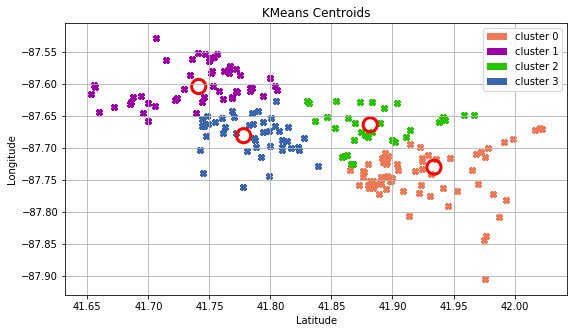

In [23]:
plot_2d_chart(centers,prediction)

In [26]:
# Set general coordinates of San Francisco city
COORDINATES = (41.881832, -87.623177) 

MAX_RECORDS = 100

In [27]:
m = folium.Map(location=COORDINATES, zoom_start=12)


In [28]:
list_loc=[]

list_pred=[]

for i in np.arange(0,k):
    pred = prediction.select("features","prediction").limit(200).collect()
    for x,y in pred:
        list_loc.append(x[0:2])
        list_pred.append(y)

In [36]:
color = ['green', 'gray', 'lightgreen', 'orange', 'pink', 'lightgray', 'blue', 'darkblue', 'black',
         'beige', 'darkred', 'cadetblue', 'purple', 'lightblue', 'darkpurple', 'darkgreen', 'lightred', 'red']
color_list = random.sample(color,k)
color_list

['darkpurple', 'lightgreen', 'darkblue', 'darkgreen']

In [37]:
#Painting the markers and circles in the map for Kmeans clustering
for i, l in enumerate(list_pred):
    folium.Marker(
        location = list_loc[i],
        popup="Cluster:"+str(l),
        icon=folium.Icon(color=color_list[l])).add_to(m)

In [38]:
folium.LayerControl().add_to(m)


In [39]:
m.save(outfile='/home/master/Escritorio/map_seda-homework2.html')

In [40]:
path = '/home/master/Escritorio/map_seda-homework2.html'
import os
rel_path = os.path.relpath(path)
from IPython.display import IFrame
IFrame(rel_path, width=900, height=650)